In [1]:
import numpy as np
import joblib
import os
import pandas as pd

# 使用网格搜索方法来进行参数选择
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from collections import Counter
# 使用StratifiedShuffleSplit类进行分层抽样
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from data_process.light_curve import ASASLightCurve

# 使用StratifiedShuffleSplit类进行分层抽样
from sklearn.model_selection import train_test_split

In [2]:
full_lc_pd = pd.read_csv("../dataset/light_curve_dataframe/cepheid/lc_cepheid.csv")

In [3]:
# delete_idx = full_lc_pd[full_lc_pd["peri_optical"].isnull() == True].index
# full_lc_pd = full_lc_pd.drop(delete_idx)

In [22]:
kim_feature = ['period', 'type', 'class_probability', 'skewness', 'kurtosis', 'shapiro_w', 'IQR',
                       'stetson_k', 'hl_amp_ratio', 'h_1', 'r21', 'r31', 'phi21',
                       'phi31', 'phase_eta', 'slope_per10', 'slope_per90', 'phase_cusum']

In [4]:
sub_class = full_lc_pd["variable_type"]
features_drop_unlabel = full_lc_pd.drop(
    labels=["source_id", "class_probability", "variable_type", "created_at", "main_type", "updated_at", "mean_vmag",
            "lksl_statistic", "rfr_score", "epoch_hjd", "e_b_v", "vector_x", "vector_y", "vector_z", "periodic"],
    axis=1)
features_drop_unlabel = features_drop_unlabel.dropna(axis=1)
# features_drop_unlabel = features_drop_unlabel.drop(labels=["peri_optical"],axis=1)
# ,"peri_optical"
features_drop_unlabel

,raj2000,dej2000,l,b,amplitude,period,mean,median,std,skewness,...,phase_eta,peri_optical,pearsonr,Mm_period_ratio,l1,slope_per10,slope_per90,slope_per20,slope_per80,phase_cusum
0,310.79987,67.24633,102.21333,15.02330,0.35,3.926633,12.624732,12.6440,0.119334,-0.293535,...,0.034235,3.215154,0.817310,0.445488,0.958295,-5.687144,8.008793,-1.898098,3.878650,0.436784
1,77.32044,-64.70331,274.78448,-35.18470,0.36,2.088684,15.190610,15.1960,0.113792,-0.030457,...,0.348689,7.272814,-0.803812,0.369049,0.830162,-0.937212,0.662440,-0.394233,0.340217,0.456209
2,77.32044,-64.70331,274.78448,-35.18470,0.36,2.088684,15.181465,15.1960,0.112264,-0.094424,...,0.393449,7.268436,-0.782158,0.201067,0.807894,-0.381057,0.363685,-0.140914,0.178288,0.435883
3,294.76155,24.38494,59.88100,1.20807,0.58,5.171102,14.729574,14.7665,0.195464,-0.056890,...,0.099079,2.848440,0.747205,0.652410,0.942369,-2.501995,3.541191,-0.933468,1.772922,0.510828
4,218.81848,-67.37944,312.68775,-6.49576,1.05,2.242517,16.050593,16.0630,0.327898,0.106559,...,0.496881,7.157402,0.562861,0.266138,0.792623,-0.268636,0.205061,-0.112563,0.114487,0.292923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4643,82.31937,-67.47275,277.68457,-32.73992,0.87,13.420894,14.071352,14.0730,0.251560,-0.314950,...,0.037554,1.048466,0.938600,0.454573,0.974491,-3.270565,3.443486,-1.536690,1.231369,0.382776
4644,273.47423,-64.60680,329.77829,-20.46853,1.20,1.730097,14.195057,14.2030,0.347610,-0.332813,...,0.127093,8.204774,-0.409689,0.202314,0.940084,-0.363470,0.910712,-0.166356,0.450779,0.483828
4645,81.16232,-66.43103,276.52916,-33.33331,0.50,8.926746,14.830084,14.8200,0.158128,0.148821,...,0.154566,1.661309,-0.471253,0.682410,0.925440,-5.456310,2.382115,-2.305983,1.216406,0.488884
4646,81.16232,-66.43103,276.52916,-33.33331,0.50,8.926746,14.840917,14.8200,0.162239,0.208626,...,0.131675,1.662523,-0.860432,0.711840,0.937132,-1.908869,1.647371,-0.872921,0.851560,0.500447


In [5]:
label_encoder = LabelEncoder()
sub_class = label_encoder.fit_transform(sub_class)
sub_class = sub_class.astype(np.int32)

In [6]:
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(features_drop_unlabel, sub_class, test_size=0.2, shuffle=True,
                                                    random_state=0)
# X_train, y_train = SMOTE().fit_resample(X_train, y_train)
X_train, y_train = SVMSMOTE(random_state=1).fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

[(0, 1633), (1, 1633), (2, 1633), (3, 1633), (4, 1633)]


In [7]:
from xgboost import XGBClassifier

param_grid = [
    {'reg_alpha': [0,2]}
]

other_params = {'learning_rate': 0.05, 'n_estimators': 500, 'max_depth': 9, 'min_child_weight': 1, 'seed': 0,
                'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_alpha': 0, 'reg_lambda': 1}

clf = XGBClassifier(n_jobs=-1, random_state=0, **other_params)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", return_train_score=True, verbose=10)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START reg_alpha=0.................................................
[CV 1/5; 1/2] END reg_alpha=0;, score=(train=1.000, test=0.930) total time=  23.6s
[CV 2/5; 1/2] START reg_alpha=0.................................................
[CV 2/5; 1/2] END reg_alpha=0;, score=(train=1.000, test=0.942) total time=  21.9s
[CV 3/5; 1/2] START reg_alpha=0.................................................
[CV 3/5; 1/2] END reg_alpha=0;, score=(train=1.000, test=0.955) total time=  23.7s
[CV 4/5; 1/2] START reg_alpha=0.................................................
[CV 4/5; 1/2] END reg_alpha=0;, score=(train=1.000, test=0.947) total time=  21.8s
[CV 5/5; 1/2] START reg_alpha=0.................................................
[CV 5/5; 1/2] END reg_alpha=0;, score=(train=1.000, test=0.938) total time=  20.8s
[CV 1/5; 2/2] START reg_alpha=2.................................................
[CV 1/5; 2/2] END reg_alpha=2;, score=(

In [10]:
grid_search.score(X_test, y_test)

0.9193548387096774

In [11]:
cvres = grid_search.cv_results_
if not os.path.exists("../output/cepheids"):
    os.makedirs("../output/cepheids")

smote = "SVMSMOTE"
with open(f"../output/cepheids/xgboost_cepheids_all_sm{smote}.txt", "w") as f:
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        f.write(str(mean_score) + "," + str(params["learning_rate"]) + "," + str(params["n_estimators"]) + "\n")



KeyError: 'learning_rate'

In [14]:
# 计算每种特征对分类结果的影响
feature_name = features_drop_unlabel.columns
feature_importances = grid_search.best_estimator_.feature_importances_
# with open(f"../output/cepheids/xgboost_cepheids_all_{smote}_feature_importance.txt", "w") as f:
#     for i in range(len(feature_importances)):
#         f.write(str(feature_importances[i]) + " " + str(feature_name[i]) + "\n")

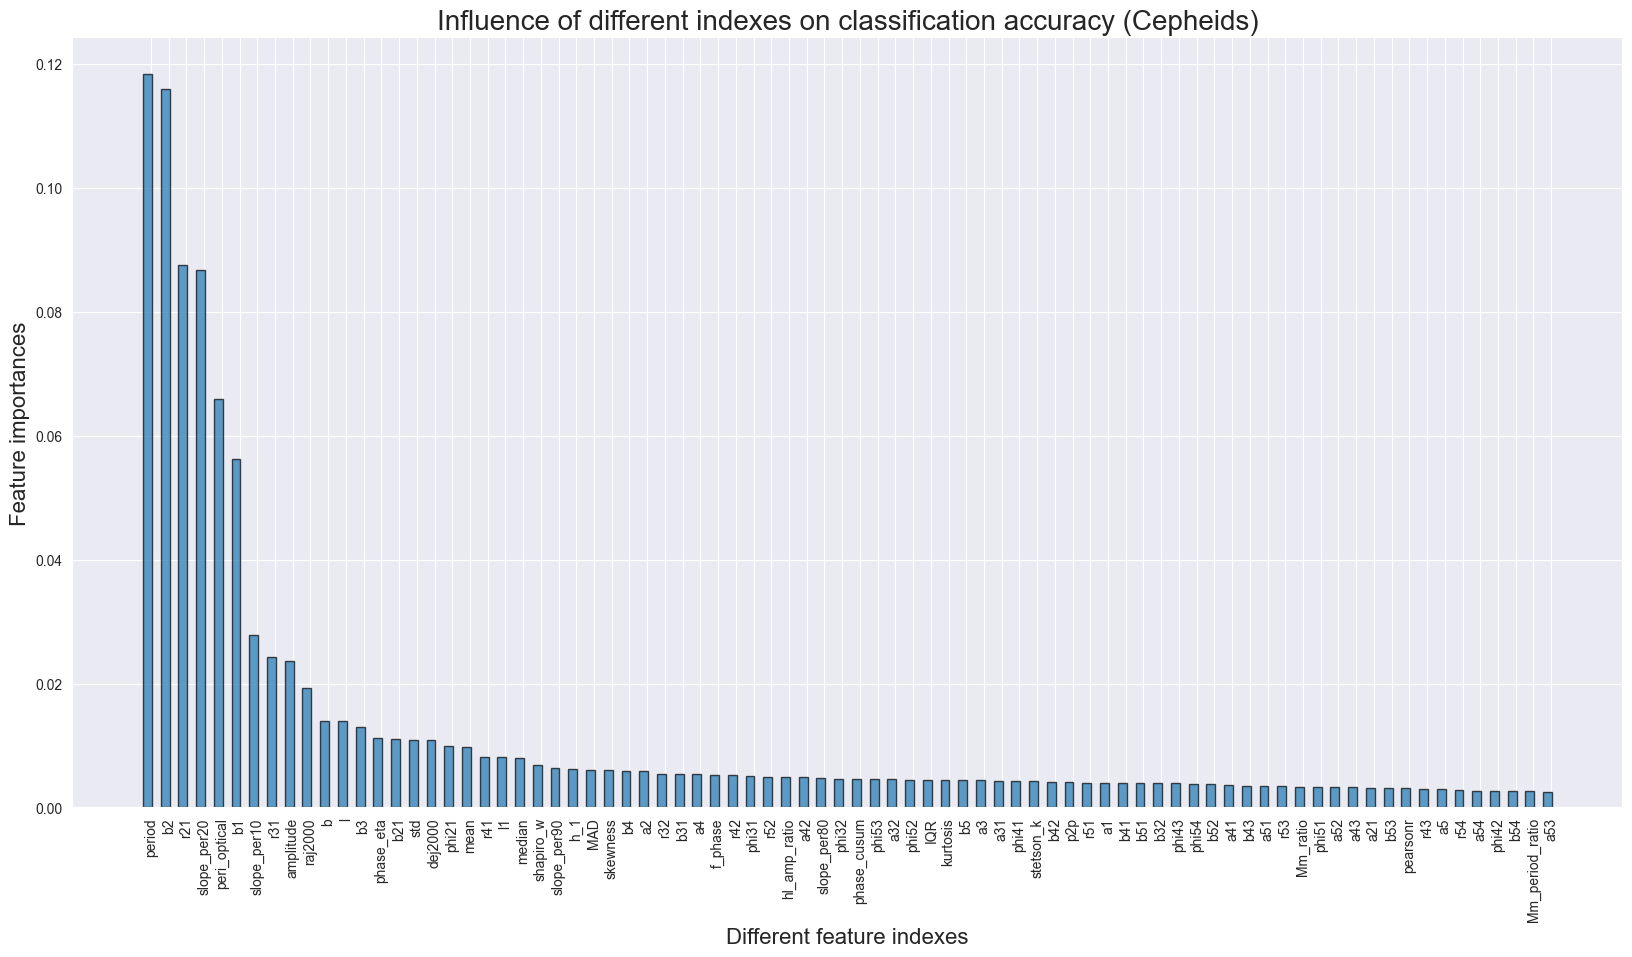

FileNotFoundError: [Errno 2] No such file or directory: './output/feature_important/random_forest_cepheids_importance_0.9425597060624616.png'

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt

importances = sorted(zip(feature_importances, feature_name), reverse=True)
feature_im = []
feature_n = []
for i in importances:
    feature_im.append(i[0])
    feature_n.append(i[1])
plt.figure(figsize=(20, 10))
indexes = np.arange(len(feature_im))
plt.title("Influence of different indexes on classification accuracy (Cepheids)", fontsize=20)
plt.xlabel("Different feature indexes", fontsize=16)
plt.ylabel("Feature importances", fontsize=16)
plt.bar(2* indexes, feature_im, 1., edgecolor="black", alpha=0.7)
# plt.bar(2 * indexes, feature_im, 2, edgecolor="black", alpha=0.7, color=['r', 'g', 'b', 'y', 'pink'])
plt.xticks(2 * indexes + 2 * 0.2, feature_n, rotation=90)
plt.show()
plt.savefig(f"./output/feature_important/random_forest_cepheids_importance_{grid_search.best_score_}.png")

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

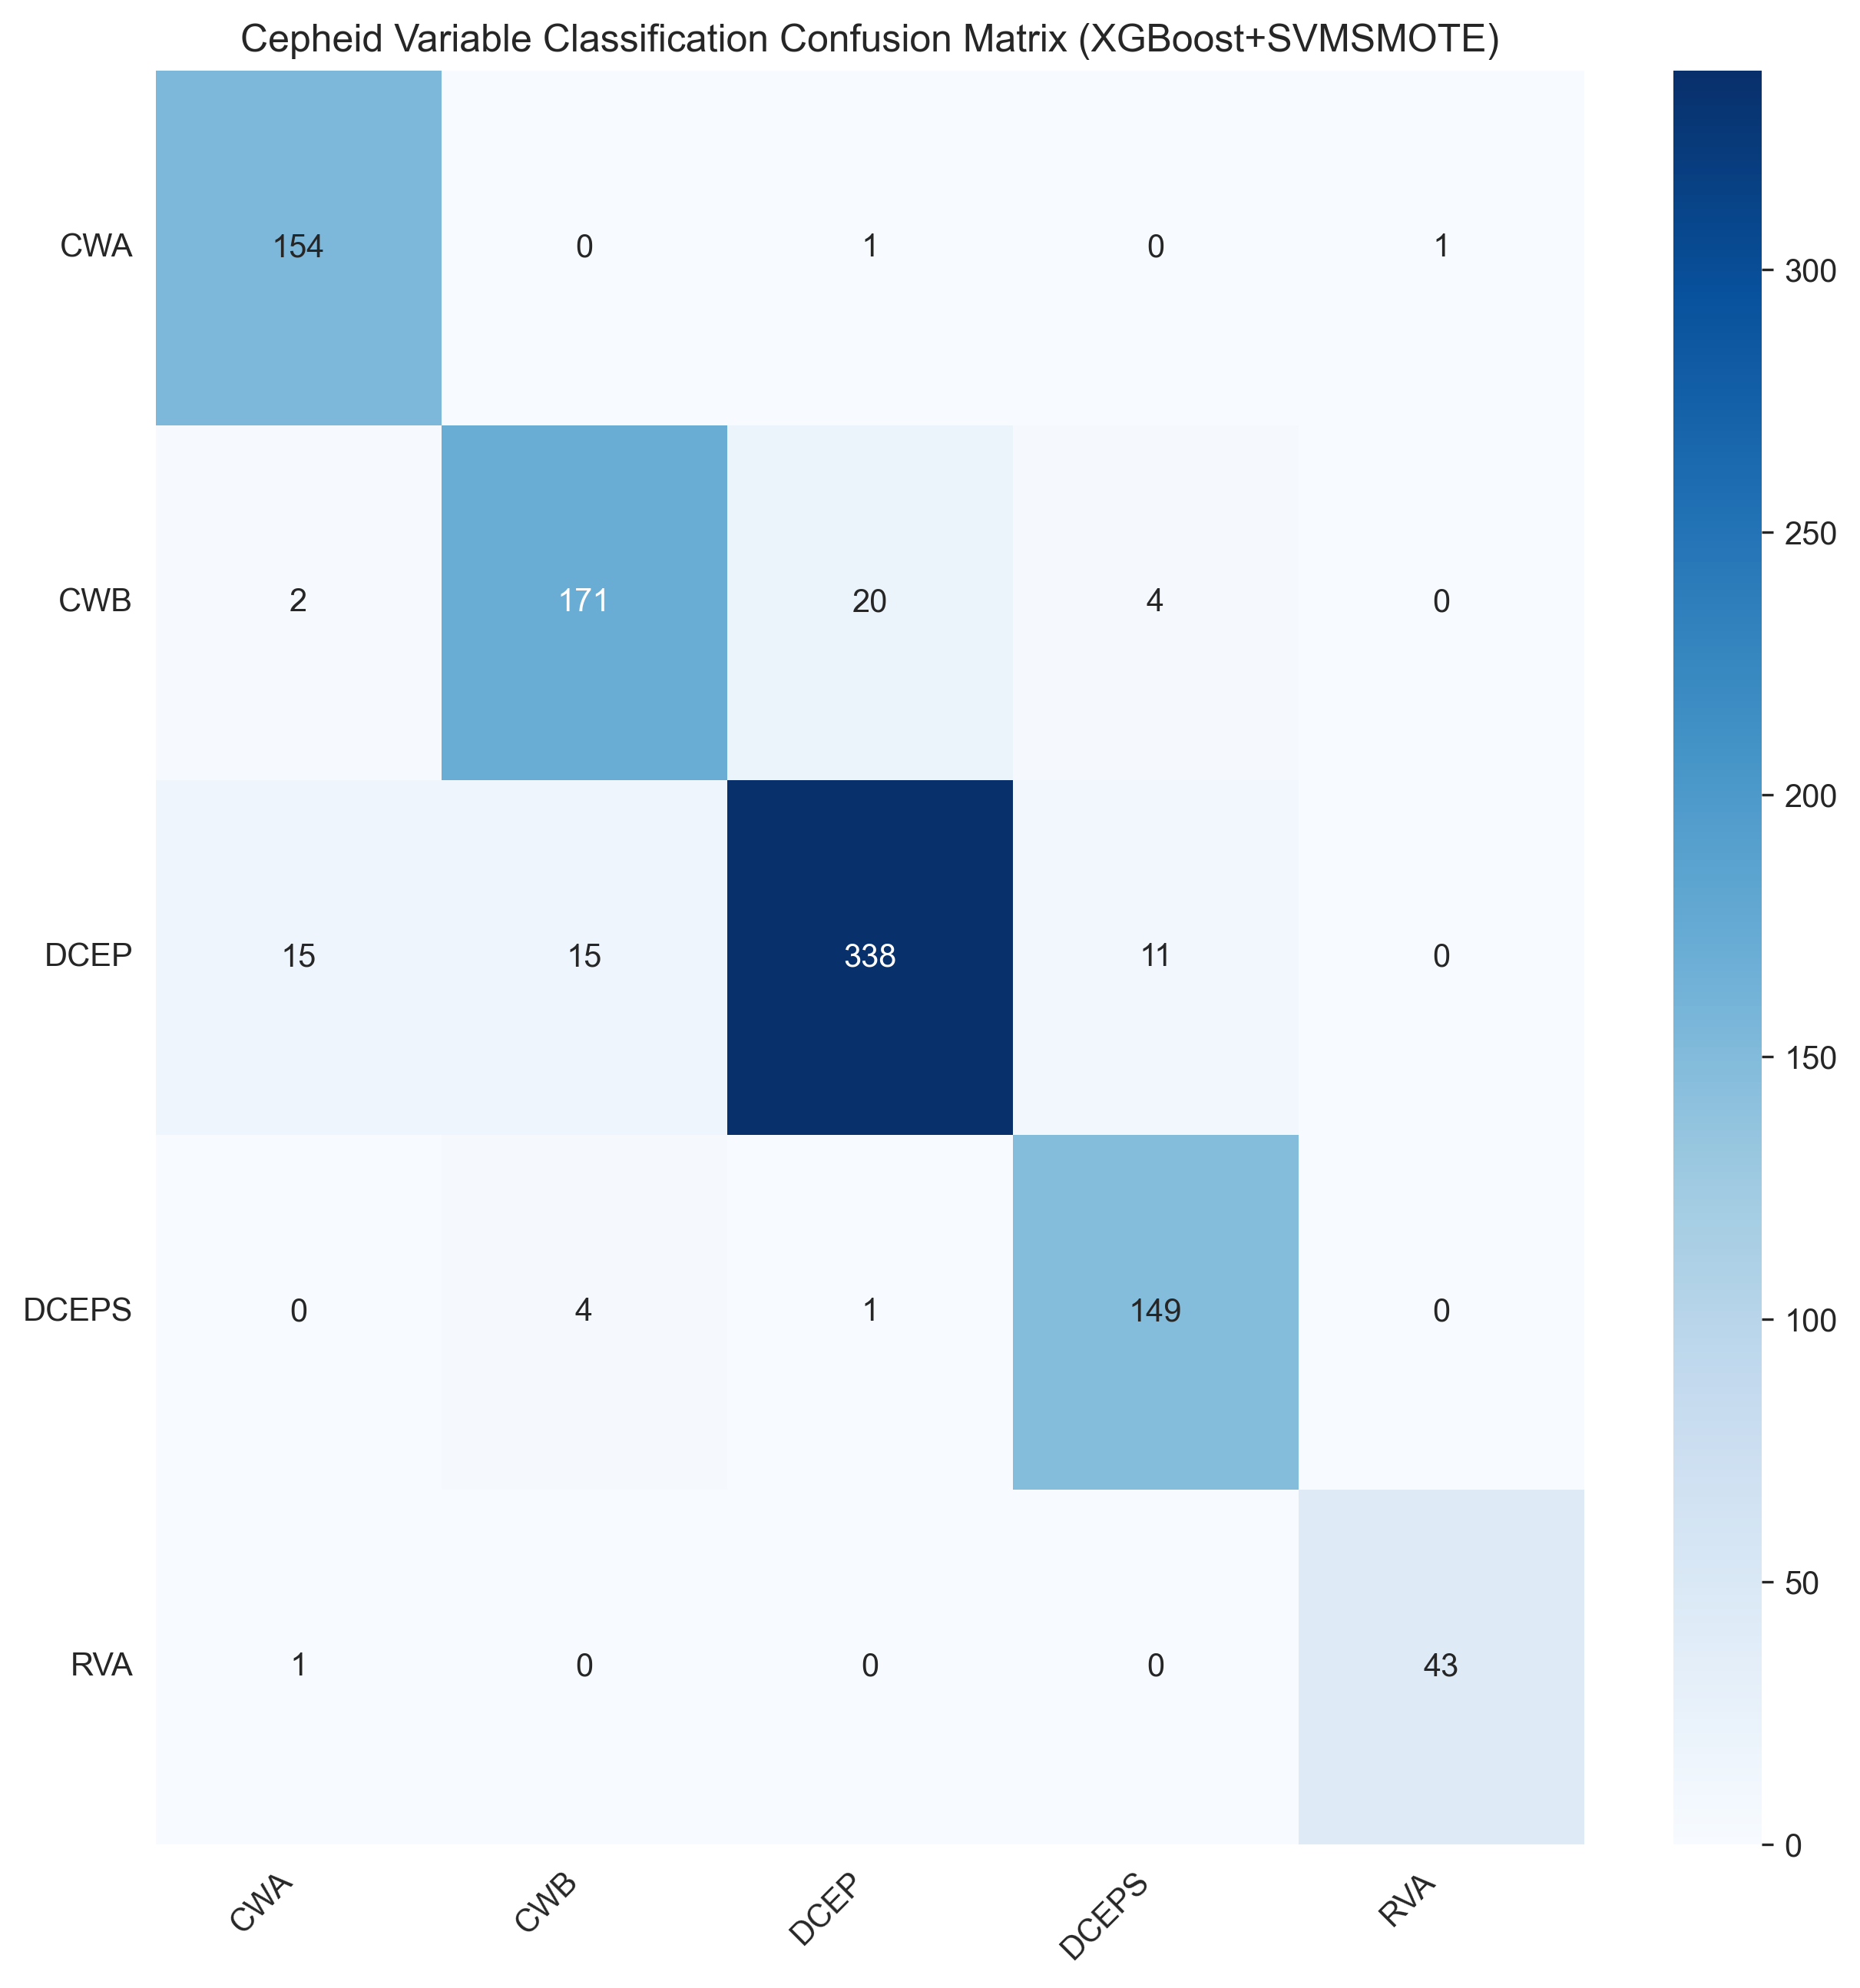

In [19]:
# from my_util.utils import plot_confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

classes = np.unique(np.concatenate([np.array(y_test), np.array(y_pred)]))
classes = label_encoder.inverse_transform(classes)
plt.figure(figsize=(10, 10), dpi=300)

heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues)
heatmap.yaxis.set_ticklabels(classes, rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(classes, rotation=45, ha='right')
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Cepheid Variable Classification Confusion Matrix (XGBoost+SVMSMOTE)')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

In [17]:
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report

print(recall_score(y_test, y_pred, average='macro'))
print(f1_score(y_test, y_pred, average='macro'))
print(precision_score(y_test, y_pred, average='macro'))
print(recall_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=classes, digits=4))

0.9383651134056288
0.9303749255386377
0.9240094077473545
0.9383651134056288
              precision    recall  f1-score   support

         CWA     0.8953    0.9872    0.9390       156
         CWB     0.9000    0.8680    0.8837       197
        DCEP     0.9389    0.8918    0.9147       379
       DCEPS     0.9085    0.9675    0.9371       154
         RVA     0.9773    0.9773    0.9773        44

    accuracy                         0.9194       930
   macro avg     0.9240    0.9384    0.9304       930
weighted avg     0.9201    0.9194    0.9189       930



In [40]:
joblib.dump(label_encoder, f"../output/models/cepheids/xgboost_cepheids_topall_smSVMSMOTE.pkl")

['../output/models/cepheids/xgboost_cepheids_topall_smSVMSMOTE.pkl']